In [4]:
import torch
from torch import nn

In [5]:
# Setup device-agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 1. Get Data

In [13]:
import requests
import zipfile
from pathlib import Path


URL = "https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip"
# Setup path to a data folder
data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'


# If the imgae folder doesn't exist, download it and prepare it
if image_path.is_dir():
    print(f'{image_path} directory already exists... skipping download')
else:
    print(f'{image_path} directory does not exist... creating one....')
    image_path.mkdir(parents=True, exist_ok=True)


# Download pizza, steak, and sushi data
with open(data_path/ 'pizza_steak_sushi.zip', 'wb') as f:
    request = requests.get(URL)
    print("Downloading pizza, steak and sushi data...")
    f.write(request.content)
    print("Download done.......")


# Unzip pizza, steak and sushi data
with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as zip_ref:
    print("Unzipping pizza, steak and sushi data")
    zip_ref.extractall(image_path)
    print("Extracted All....")



data/pizza_steak_sushi directory already exists... skipping download
Download done.......
Unzipping pizza, steak and sushi data
Extracted All....


## 2. Becoming one with data (data preparation and exploration)

In [14]:
import os
def walk_through_dir(dir_path):
    """Walk through dir_path returning its content"""
    for dirpath, dirnames, filename in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filename)} images in '{dirpath}'")

walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'


In [15]:
# Setup train and testing paths
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing and Image
Let's write some code to:
1. Get all of the image paths
2. Pick a random image path using Python's `random.choice()`
3. Get the image ckass name using `pathlib.Path.parent.stem`
4. Since we are working with images, let's open the image with Python's PIL
5. We'll then show the image and print metadata

In [17]:
 image_path

PosixPath('data/pizza_steak_sushi')

Random image path: data/pizza_steak_sushi/test/sushi/2540511.jpg
Image Class: sushi
Image Height: 512
Image Width: 512


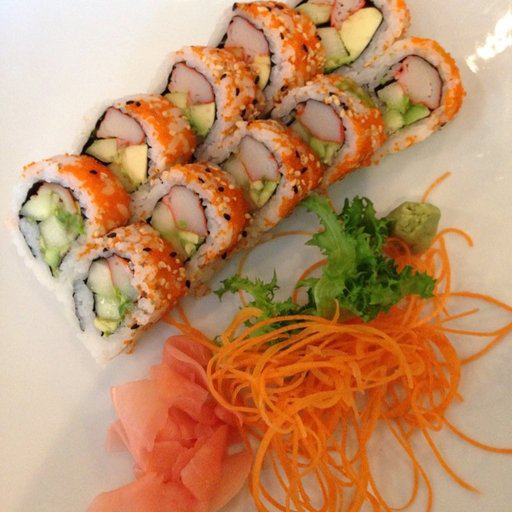

In [34]:
## import random
from PIL import Image

# Set seed
# random.seed(42)

# 1. Get all the image paths
image_path_list = list(image_path.glob('*/*/*.jpg'))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get the image class name from the path name (the image classs is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open Image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image Class: {image_class}")
print(f"Image Height: {img.height}")
print(f"Image Width: {img.width}")
img


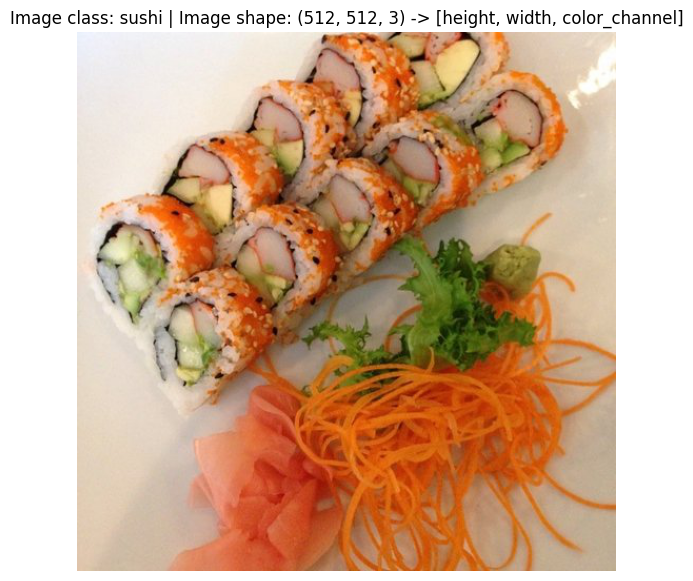

In [35]:
import numpy as np
import matplotlib.pyplot as plt

img_as_np_array = np.asarray(img)

plt.figure(figsize=(10,7))
plt.imshow(img_as_np_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_np_array.shape} -> [height, width, color_channel]")
plt.axis(False)
plt.show()

## 3. tranforming Data

Before we can use our image data with PyTorch:

1. Turn our target data into tensors (in our case, numerical representation of our image)
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader`


In [36]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [38]:
data_transform = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size=(64,64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])


In [40]:
data_transform(img).shape

torch.Size([3, 64, 64])

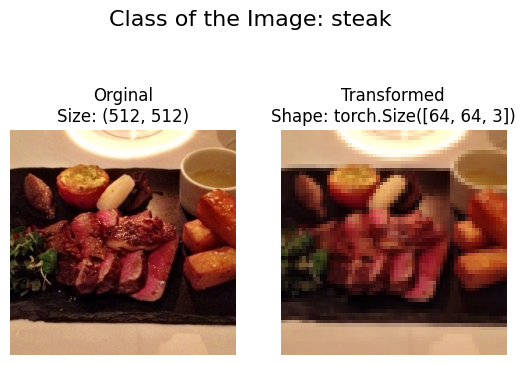

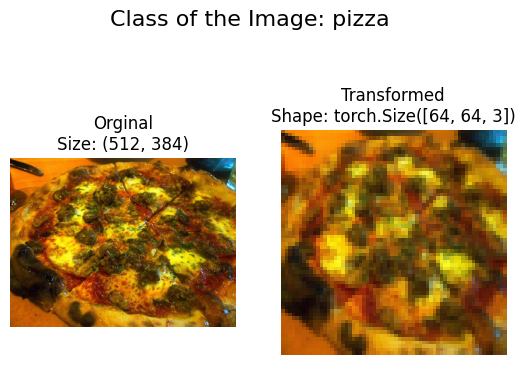

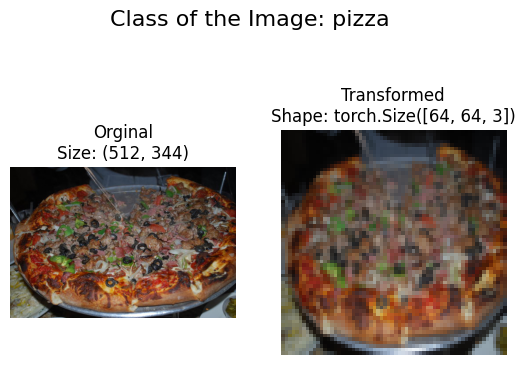

In [42]:
def plot_tranformed_images(image_paths: list, transform, n=3, seed=None):
    """Plots a series of random images from image_paths.
    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    if seed:
        random.seed(seed)
    
    # Select k randomly image paths from the image paths list
    random_img_paths = random.sample(image_paths, k=n)
    # loop through the paths
    for path in random_img_paths:
        # open the image
        with Image.open(path) as f:
            # create the subplot (2 img in 1 row)
            fig, ax = plt.subplots(nrows=1, ncols=2)
            # show the image
            ax[0].imshow(f)
            ax[0].set_title(f"Orginal\nSize: {f.size}")
            ax[0].axis(False)


            # Transform the image and plot
            transformed_img = transform(f).permute(1,2,0) # our tensor shape is [C,H,W]. turn it to [H,w,C] as its matplotlib
            ax[1].imshow(transformed_img)
            ax[1].set_title(f'Transformed\nShape: {transformed_img.shape}')
            ax[1].axis(False)


            fig.suptitle(f"Class of the Image: {path.parent.stem}", fontsize=16)


plot_tranformed_images(image_paths=image_path_list, transform=data_transform, n=3, seed=None)

    

## 4. Option 1 Loading Image data with `ImageFolder`

In [44]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [45]:
from torchvision import datasets
# Use ImageFolder to create dataset
train_data = datasets.ImageFolder(root=train_dir, transform=data_transform, target_transform=None)
test_data = datasets.ImageFolder(root=test_dir, transform=data_transform, target_transform=None)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [50]:
# class names and class dict (with numeric value to the class label)
class_names = train_data.classes
class_dict = train_data.class_to_idx
class_names, class_dict

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [53]:
# fisrt 5 samples
train_data.samples[0:5]

[('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1033251.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1044789.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1089334.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1105700.jpg', 0)]

In [57]:
# See the one image (tensor from) and its label
tensor_img , label = train_data[0]
print(f"Image tensor:\n {tensor_img}")
print(f"Image shape: {tensor_img.shape}")
print(f"Image datatype: {tensor_img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")
     

Image tensor:
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0706, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0196, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'pizza')

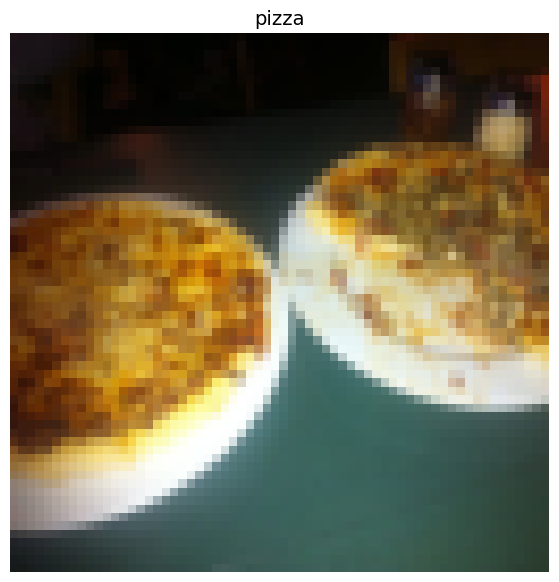

In [58]:
# Rearrange the order dimensions
img_permute = tensor_img.permute(1, 2, 0)

# Print out different shapes
print(f"Original shape: {tensor_img.shape} -> [color_channels, height, width]")
print(f"Image permute: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=14)

### 4.1 Turn loaded images into `DataLoader`

In [60]:
import os
os.cpu_count()

8

In [64]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, num_workers=1, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, num_workers=1)

# see what we have created
print(f"Length of train dataloaders: {len(train_dataloader)} batchs of {BATCH_SIZE}")
print(f"Length of test dataloaders: {len(test_dataloader)} batchs of {BATCH_SIZE}")

Length of train dataloaders: 8 batchs of 32
Length of test dataloaders: 3 batchs of 32


In [65]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, you can change the batch size if you like
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


## 5. Option 2: Loading Image Data with a Custom Dataset
1. Want to be able to load images from file
2. Want to be able to get class names from the Dataset
3. Want to be able to get classes as dictionary from the Dataset

In [66]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [67]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names
We want a function to:

1. Get the class names using os.scandir() to traverse a target directory (ideally the directory is in standard image classification format).
2. Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure).
3. Turn the class names into a dict and a list and return them.

In [68]:
# Setup path for target directory
target_directory = train_dir
print(f"Target dir: {target_directory}")

# Get the class names from the target directory 
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [69]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """Finds the class folder names in a target directory."""
  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}... please check file structure.")

  # 3. Create a dictionary of index labels (computers prefer numbers rather than strings as labels)
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
  return classes, class_to_idx

In [72]:
find_classes(target_directory)


(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom Dataset to replicate ImageFolder
To create our own custom dataset, we want to:

1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory (the directory we'd like to get data from) as well as a transform if we'd like to transform our data.
3. Create several attributes:
    - paths - paths of our images
    - transform - the transform we'd like to use
    - classes - a list of the target classes
    - class_to_idx - a dict of the target classes mapped to integer labels
4. Create a function to load_images(), this function will open an image
5. Overwrite the __len()__ method to return the length of our dataset
6. Overwrite the __getitem()__ method to return a given sample when passed an index

In [73]:
# 0. Write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  # 2. Initialize our custom dataset
  def __init__(self, 
               targ_dir: str, 
               transform=None):
    # 3. Create class attributes
    # Get all of the image paths
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    # Setup transform
    self.transform = transform
    # Create classes and class_to_idx attributes
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # 4. Create a function to load images
  def load_image(self, index: int) -> Image.Image:
    "Opens an image via a path and returns it."
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite __len__()
  def __len__(self) -> int:
    "Returns the total number of samples."
    return len(self.paths)
  
  # 6. Overwrite __getitem__() method to return a particular sample
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    "Returns one sample of data, data and label (X, y)."
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx # return data, label (X, y)
    else:
      return img, class_idx # return untransformed image and label
     

In [74]:
# Create a transform
from torchvision import transforms
train_transforms = transforms.Compose([
                                      transforms.Resize(size=(64, 64)),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.ToTensor() 
])

test_transforms = transforms.Compose([
                                      transforms.Resize(size=(64, 64)),
                                      transforms.ToTensor()
])

# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)

In [75]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

### 5.3 Create a function to display random images
1. Take in a Dataset and a number of other parameters such as class names and how many images to visualize.
2. To prevent the display getting out of hand, let's cap the number of images to see at 10.
3. Set the random seed for reproducibility
4. Get a list of random sample indexes from the target dataset.
5. Setup a matplotlib plot.
6. Loop through the random sample indexes and plot them with matploltib.
7. Make sure the dimensions of our images line up with matplotlib (HWC)

In [76]:
# 1. Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  # 2. Adjust display if n is too high
  if n > 10:
    n = 10
    display_shape = False
    print(f"For display, purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

  # 3. Set the seed
  if seed:
    random.seed(seed)

  # 4. Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  # 5. Setup plot
  plt.figure(figsize=(16, 8))

  # 6. Loop through random indexes and plot them with matplotlib
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # 7. Adjust tensor dimensions for plotting
    targ_image_adjust = targ_image.permute(1, 2, 0) # [color_channels, height, width] -> [height, width, color_channels]

    # Plot adjusted samples
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"
    plt.title(title) 
     

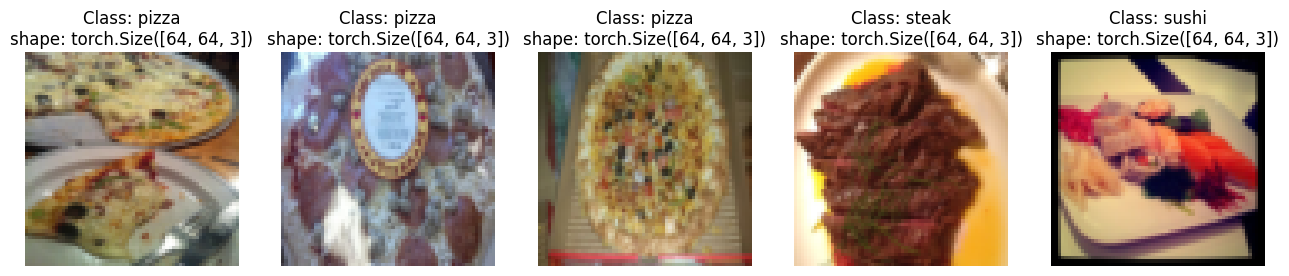

In [77]:

# Display random images from the ImageFolder created Dataset
display_random_images(train_data,
                      n=5, 
                      classes=class_names,
                      seed=None)

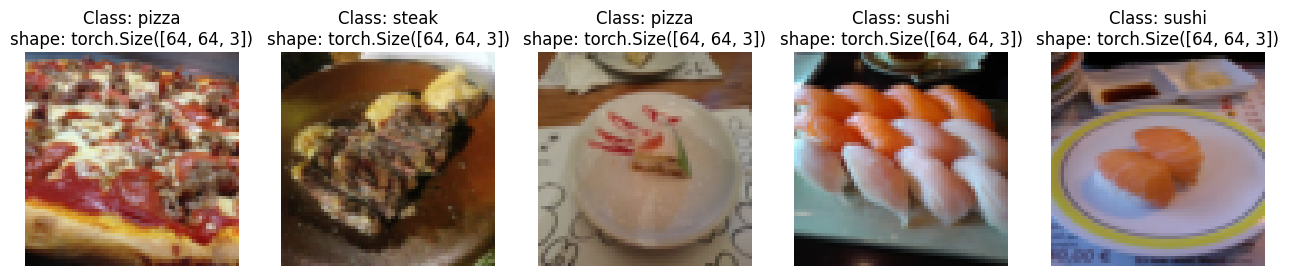

In [78]:
# Display random images from the ImageFolderCustom Dataset
display_random_images(train_data_custom,
                      n=5,
                      classes=class_names,
                      seed=None)

In [79]:
from torch.utils.data import DataLoader
BATCH_SIZE = 1
NUM_WORKERS = os.cpu_count()
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)

train_dataloader_custom, test_dataloader_custom
     

(<torch.utils.data.dataloader.DataLoader at 0x7fe5b877c9b0>,
 <torch.utils.data.dataloader.DataLoader at 0x7fe5ba0973b0>)

In [80]:

# Get image and label from custom datloader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Print out the shapes
img_custom.shape, label_custom.shape

(torch.Size([1, 3, 64, 64]), torch.Size([1]))

## 6. Other forms of transformation (Data Augmentation)

In [83]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])


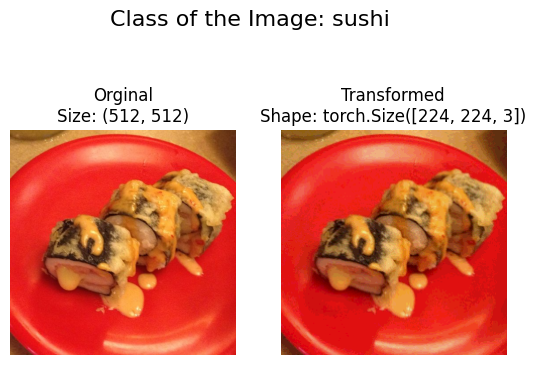

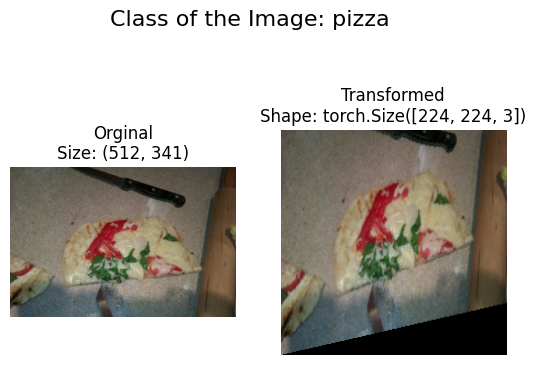

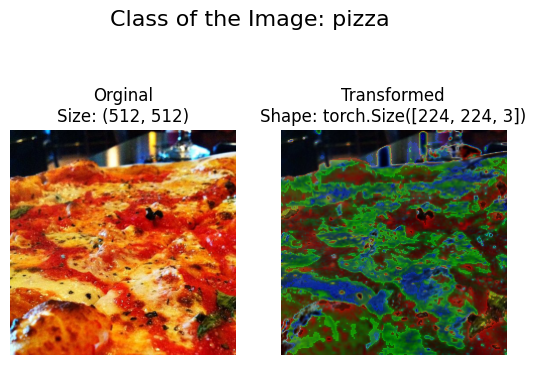

In [84]:
plot_tranformed_images(image_paths=image_path_list, transform=train_transform,n=3, seed=None)

## 7. Model 0: TinyVGG without data augmentation

### 7.1 Creating transforms and loading data for model 0

In [87]:
# Create simple transforms
simple_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])


In [88]:
# Load and transform data
from torchvision import datasets

train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

# Turn the dataset into DataLoader
import os
from torch.utils.data import DataLoader

NUM_WORKERS = 1
BATCH_SIZE = 32


train_dataloader_simple = DataLoader(dataset=train_data_simple, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
test_dataloader_simple = DataLoader(dataset=test_data_simple, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)

In [89]:
class TinyVGG(nn.Module):
  """
  Model architecture copying TinyVGG from CNN Explainer: https://poloclub.github.io/cnn-explainer/
  """
  def __init__(self, 
               input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default stride value is same as kernel_size
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default stride value is same as kernel_size
    )
    self.classifier = nn.Sequential(
        nn.Flatten(), 
        nn.Linear(in_features=hidden_units*13*13,
                  out_features=output_shape)
    )

  def forward(self, x):
    return self.classifier(self.conv_block_2(self.conv_block_1(x)))
    

In [90]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels in our image data
                  hidden_units=10, 
                  output_shape=len(class_names)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [92]:
# Get a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [93]:

# Try a forward pass
model_0(image_batch.to(device))

tensor([[ 0.0196, -0.0013,  0.0109],
        [ 0.0209,  0.0001,  0.0089],
        [ 0.0198, -0.0038,  0.0090],
        [ 0.0191, -0.0013,  0.0103],
        [ 0.0228, -0.0037,  0.0093],
        [ 0.0245, -0.0048,  0.0085],
        [ 0.0209,  0.0001,  0.0084],
        [ 0.0224, -0.0014,  0.0080],
        [ 0.0179,  0.0004,  0.0087],
        [ 0.0186, -0.0042,  0.0095],
        [ 0.0182, -0.0002,  0.0076],
        [ 0.0183, -0.0008,  0.0152],
        [ 0.0183,  0.0002,  0.0060],
        [ 0.0213, -0.0039,  0.0110],
        [ 0.0232, -0.0034,  0.0095],
        [ 0.0199, -0.0023,  0.0090],
        [ 0.0202, -0.0023,  0.0073],
        [ 0.0211, -0.0018,  0.0083],
        [ 0.0203,  0.0033,  0.0065],
        [ 0.0218, -0.0002,  0.0091],
        [ 0.0186, -0.0020,  0.0091],
        [ 0.0205, -0.0026,  0.0085],
        [ 0.0208,  0.0018,  0.0079],
        [ 0.0194,  0.0017,  0.0103],
        [ 0.0216, -0.0044,  0.0095],
        [ 0.0195, -0.0022,  0.0099],
        [ 0.0197, -0.0009,  0.0093],
 

In [94]:
# Install torchinfo, import if it's available
try:
  import torchinfo
except:
  !pip -qqq install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

In [95]:
# Create train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device=device):
  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to the target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X) # output model logits

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate accuracy metric
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)
  
  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader) 
  return train_loss, train_acc 
     

In [96]:
# Create a test step
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0,  0

  # Turn on inference mode
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader): 
      # Send data to the target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)

      # 2. Calculate the loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate the accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc